# Important factor for Food Poisoning ? 

In [2]:
import warnings
import requests
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import folium
import geopandas as gpd
import folium
import folium.plugins as plugins
import scipy.stats as stats

from matplotlib.ticker import MaxNLocator
from requests import get
from IPython.display import IFrame
from pandas.io.json import json_normalize
from shapely.geometry import Polygon
from shapely.geometry import Point
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score , precision_score , f1_score, recall_score, matthews_corrcoef, roc_auc_score
from sklearn.metrics import classification_report 

# self made classes
from violation_preprocessing import violation_separator, violations_dataframe
from mapping_functions import chlorepleth_map, geodataframe, generateBaseMap, adding_CircleMarker, adding_Marker

# to ignore the warnings and make the notebook more presentable
warnings.filterwarnings('ignore') 
%matplotlib inline
sns.set()

# Evaluating Risk factors 

Let's take the data with the violations of each restaurant in Chicago.

In [3]:
data = pd.read_csv('data/clean_dataset.csv')

del data['Unnamed: 0']

# convert the zip column into an str
data.zip = data.zip.astype(str)
    
# reformat the zip code writing in order to compare it with the zip code in geojson file (for vizualisation step)
data['zip'] = data['zip'].apply(lambda x : x.split('.')[0])

In [4]:
data.head(2)

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
0,2352734,CHILI'S T-I,CHILI'S (T1-B14),34169.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,60666,2019-12-04,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'..."
1,2352727,PORTAGE PARK DAY NURSERY,MOSAIC EARLY CHILDHOOD ACADEMY,2215815.0,Children's Services Facility,Risk 1 (High),5332-5334 W ADDISON ST,60641,2019-12-04,Canvass,Pass,NaN,41.946065,-87.760722,"{'latitude': '-87.76072227616888', 'longitude'..."


In [5]:
#calculating the number of facilities per zip for the normalization 
data_zip=pd.DataFrame(data.groupby('zip')['inspection_id'].count())
data_zip.rename(columns = {'inspection_id': 'total_count'}, inplace = True)
data_zip.reset_index()

data_zip.head(3)

,total_count
zip,
60601,2517
60602,1099
60603,1408


This dataset gives us the following informations :  
1. The risk level of the restaurants (a factor for Ecoli poisoning) in each zip code
2. The amount of food poisoning per zip code

In [6]:
#we just want to extract the level of risk ( 1 , 2 ou 3)
data['risk']=data['risk'].astype(str) 
data['risk_level'] = data['risk'].str[5]

data['risk_level']=data['risk_level'].astype(float)

#counting the number of facilities with inspection due to suspected food poisoning
poisoning_data = data[data['inspection_type'] == 'Suspected Food Poisoning']

In [7]:
# Create bars
risk_level_count=list(poisoning_data.groupby('risk_level')['inspection_id'].count())
total=len(poisoning_data)
percentage = [ (a/total)*100 for a in risk_level_count]



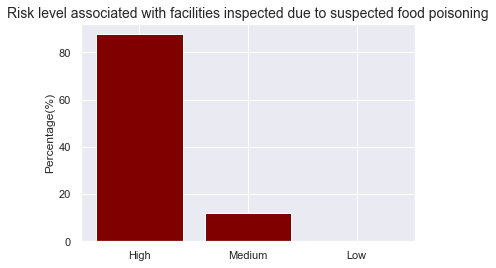

In [8]:
height = percentage
bars = ('High','Medium','Low')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height,color='maroon')
 
# Create names on the x-axis
plt.xticks(y_pos, bars)


plt.title('Risk level associated with facilities inspected due to suspected food poisoning',fontsize=14)
plt.ylabel('Percentage(%)', fontsize=12)
# Show graphic
plt.show()

### Proportion of inspection due to suspected food poisoning per zip

In [9]:
# counting the number of facilities per zip 
facility_number_per_zip = pd.DataFrame(data.groupby('zip')['license'].count()).reset_index()


pois_facility_number_per_zip= pd.DataFrame(poisoning_data.groupby('zip')['license'].count()).reset_index()

#merge in order to calculate the proportion
number_facilities_df= pd.merge(facility_number_per_zip, pois_facility_number_per_zip, on='zip')
number_facilities_df.rename(columns = {'license_x': 'total number', 'license_y':'poisoning number'}, inplace = True)

#frequency of inspection due to food poisoning in a given zip
number_facilities_df['frequency(%)']=number_facilities_df['poisoning number'].divide(number_facilities_df['total number'])*100



In [10]:
number_facilities_df.head(2)

,zip,total number,poisoning number,frequency(%)
0,60601,2517,25,0.993246
1,60602,1099,6,0.545951


### Average risk level per zip

The risk level of the restaurants:

In [11]:
risk_per_zip = data[['zip','risk_level']]
risk_per_zip = data[data['risk_level'] == 1.0 ]

# counting the number of facilities per zip code where the risk is high
risk_per_zip = pd.DataFrame(risk_per_zip.groupby('zip')['inspection_id'].count())
risk_per_zip=risk_per_zip.reset_index()

risk_per_zip.rename(columns = {'inspection_id': 'high_risk_count'}, inplace = True)

risk_per_zip=pd.merge(risk_per_zip,data_zip,on='zip')

risk_per_zip['percentage']= risk_per_zip['high_risk_count'].divide(risk_per_zip['total_count'])*100


risk_per_zip.head(3)

,zip,high_risk_count,total_count,percentage
0,60601,2010,2517,79.856973
1,60602,856,1099,77.888990
2,60603,1167,1408,82.883523


In [12]:
#Map showing the repartition of average risk level in chicago per zip code


# creating our geodataframe based on the basic dataframe
gdf = geodataframe(data)
gdf.head(3)
    
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}


# merge with gdf dataframe  
risk_gdf = pd.merge(gdf,risk_per_zip, on = 'zip')

risk_map = chlorepleth_map ('Risk proportion',risk_gdf,['zip','percentage'],'Average Risk Level','YlOrRd')

RIL = folium.features.GeoJson(
    risk_gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['zip','percentage'],
        aliases=['Zip: ','Proportion of facilities associated with high risk :'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
risk_map.add_child(RIL)
risk_map.keep_in_front(RIL)
folium.LayerControl().add_to(risk_map)

risk_map.save('maps/interactif_risk_map.html')

In [13]:
#merge with the frequency dataset without central fusion 
risk_correlation=pd.merge(number_facilities_df,risk_per_zip,on='zip')

risk_correlation.head(3)

,zip,total number,poisoning number,frequency(%),high_risk_count,total_count,percentage
0,60601,2517,25,0.993246,2010,2517,79.856973
1,60602,1099,6,0.545951,856,1099,77.888990
2,60603,1408,16,1.136364,1167,1408,82.883523


Text(89.27181208053692, 0.18278523489932885, '60656')

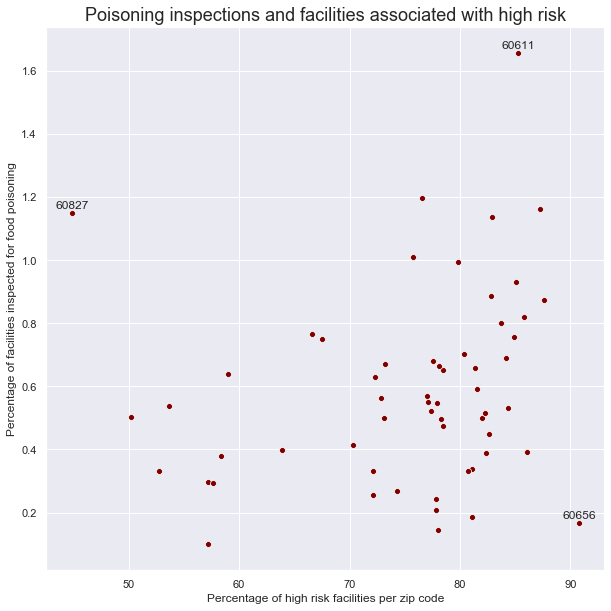

In [14]:
fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.scatterplot(x = risk_correlation['percentage'], y = risk_correlation['frequency(%)'], ax = ax, color = 'maroon')




# label the axis accordingly
plt.xlabel('Percentage of high risk facilities per zip code')
plt.ylabel('Percentage of facilities inspected for food poisoning')
plt.title('Poisoning inspections and facilities associated with high risk',fontSize=18)

plt.text(risk_correlation.percentage.values[57]-1.5 ,risk_correlation['frequency(%)'].values[57] +0.015,risk_correlation.zip.values[57] , fontSize = 12)

plt.text(risk_correlation.percentage.values[10]-1.5 ,risk_correlation['frequency(%)'].values[10] +0.015,risk_correlation.zip.values[10] , fontSize = 12)

plt.text(risk_correlation.percentage.values[50]-1.5 ,risk_correlation['frequency(%)'].values[50] +0.015,risk_correlation.zip.values[50] , fontSize = 12)



focus only on 60827 (haut poisoning percentage et bas risk ) , 60621 et 60656 (bas poisoning higgh risk level facilities et 60611 reflete max correlation .
Obervations : 
> 60827 : low high risk proportion , low number of sanitation violations but high number of food poisoning and number of failed inspections. Why ? cf datastory of Riverdale 

The spearman coefficient is :  SpearmanrResult(correlation=0.37760421370164654, pvalue=0.0044815939194058916)


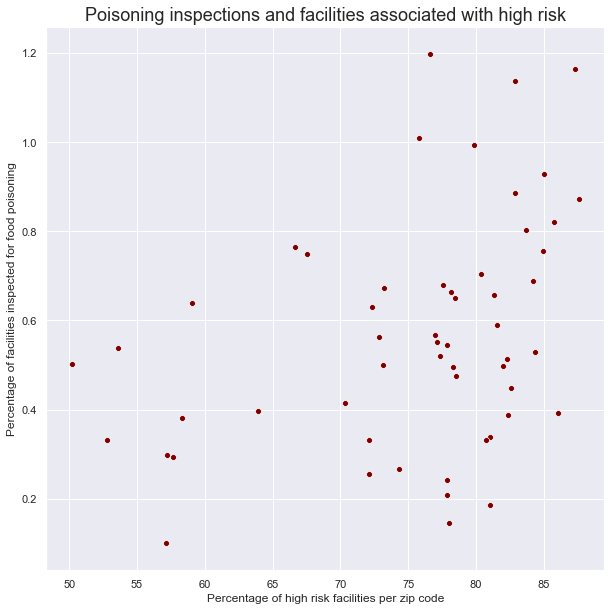

In [15]:
#we remove 'outliers'
outliers=['60827','60656','60611']

risk_correlation_without_outliers=risk_correlation.query('zip != @outliers')

fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.scatterplot(x = risk_correlation_without_outliers['percentage'], y = risk_correlation_without_outliers['frequency(%)'], ax = ax, color = 'maroon')




# label the axis accordingly
plt.xlabel('Percentage of high risk facilities per zip code')
plt.ylabel('Percentage of facilities inspected for food poisoning')
plt.title('Poisoning inspections and facilities associated with high risk',fontSize=18)

#spearman coeff 
print('The spearman coefficient is : ',stats.spearmanr(risk_correlation_without_outliers['percentage'],risk_correlation_without_outliers['frequency(%)']))


# FAILURE AND POISONING 

In [16]:
# Create bars
results_count=list(poisoning_data.groupby('results')['inspection_id'].count())
total=len(poisoning_data)
percentage = [ (a/total)*100 for a in results_count]

poisoning_data.groupby('results').count()

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,zip,inspection_date,inspection_type,violations,latitude,longitude,location,risk_level
results,,,,,,,,,,,,,,,
Fail,214,214,214,214,214,214,214,214,214,214,211,214,214,214,214
Pass,394,394,392,394,394,394,394,394,394,394,377,394,394,394,394
Pass w/ Conditions,231,231,230,231,231,231,231,231,231,231,230,231,231,231,231


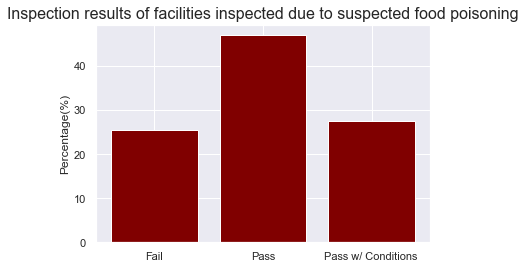

In [17]:
height = percentage
bars = ('Fail','Pass','Pass w/ Conditions ')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height,color='maroon')
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.title('Inspection results of facilities inspected due to suspected food poisoning',fontsize=16)
plt.ylabel('Percentage(%)')
# Show graphic
plt.show()

Main conclusion : we can't use the inspection results in order to assess food safety within a facility. We need to investigate more to understand what factors may cause foodborn illness.